In [20]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp

plt.style.use("seaborn-v0_8-whitegrid") 
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
})

### Gillespie's Algorithm

In [58]:
import numpy as np
from scipy.integrate import solve_ivp

def sir_rhs(t, y, beta, gamma,mu, N):
    """
    Frequency-dependent SIR with COUNTS (X,Y,Z) and fixed population N.
    dX/dt = -beta * X * Y / N
    dY/dt =  beta * X * Y / N - gamma * Y
    dZ/dt =  gamma * Y
    """
    X, Y, Z = y
    
    dX = mu * N - beta * X * Y / N - mu * X
    dY = beta * X * Y / N - gamma * Y - mu * Y
    dZ = gamma * Y - mu * Z
    return [dX, dY, dZ]
    


def integrate_sir(beta, gamma, mu, N, X0, Y0, Z0,
                         t_span=(0.0, 160.0), num_points=1000, method="RK45"):
    """
    Minimal integrator wrapper for counts-based frequency-dependent SIR.
    Returns dict with t, X, Y, Z (arrays).
    """

    y0 = [float(X0), float(Y0), float(Z0)]
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    sol = solve_ivp(
        lambda t, y: sir_rhs(t, y, beta, gamma, mu, N),
        t_span, y0, t_eval=t_eval, method=method,
        rtol=1e-8, atol=1e-10
    )

    # Numerical safety: clip tiny negatives from solver noise
    
    Y = np.clip(sol.y, 0.0, None)
    return {"t": sol.t, "X": Y[0], "Y": Y[1], "Z": Y[2]}


def gillespie_sir(beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=None):
    """
    infectionL (X - 1, Y + 1), rate_1 = beta * X * Y / N
    recovery: (Y - 1, Z + 1), rate_2 = gamma * Y
    birth:  (X + 1), rate_3 = mu * N
    deathX: (X - 1), rate_4 = mu * X
    deathY: (Y - 1), rate_5 = mu * Y
    deathZ: (Z - 1), rate_6 = mu * Z
    """
    if rng is None:
        rng = np.random.default_rng()

    # Validate & coerce to ints
    
    X, Y, Z = int(X0), int(Y0), int(Z0)
    t = 0.0
    
    times = [0.0]
    X_hist, Y_hist, Z_hist = [X], [Y], [Z]

    while t < tmax and Y > 0:
        rate_I = beta * X * Y / N   # infection
        rate_R = gamma * Y
        rate_B = mu * N              # birth
        rate_DX = mu * X             # death of susceptible
        rate_DY = mu * Y             # death of infected
        rate_DZ = mu * Z             # death of recovered
        total_rate = rate_I + rate_R + rate_B + rate_DX + rate_DY + rate_DZ

        # exponential waiting time
        t += -np.log(rng.random()) /  total_rate

        r  = rng.random() * total_rate
        
        if r < rate_I:
            if X > 0: X -= 1; Y += 1
        elif r < rate_I + rate_R:
            if Y > 0: Y -= 1; Z += 1
        elif r < rate_I + rate_R + rate_B:
            X += 1
        elif r < rate_I + rate_R + rate_B + rate_DX:
            if X > 0: X -= 1
        elif r < rate_I + rate_R + rate_B + rate_DX + rate_DY:
            if Y > 0: Y -= 1
        else:
            if Z > 0: Z -= 1

        times.append(t); X_hist.append(X);Y_hist.append(Y);Z_hist.append(Z)

    return np.array(times), np.array(X_hist), np.array(Y_hist), np.array(Z_hist)


In [59]:
def resample_step(times, values, t_grid):
    """Piecewise-constant resampling of an event-driven trajectory."""
    
    out = np.empty_like(t_grid, dtype=float)
    j = 0
    curr = values[0]
    for k, tk in enumerate(t_grid):
        while j + 1 < len(times) and times[j + 1] <= tk:
            j += 1
            curr = values[j]
        out[k] = curr
    return out

In [74]:
# Compare stochastic and deterministic SIR models

beta = 0.5
gamma = 0.1
mu = 1/50
N = 1000
I0 = 10
S0 = N - I0
R0 = 0

t_span = (0.0, 160.0)
num_points = 1000
t_grid = np.linspace(t_span[0], t_span[1], num_points)

# Deterministic solution
det = integrate_sir(beta, gamma, mu, N, S0, I0, R0,
                        t_span=t_span, num_points=num_points)

# Stochastic replicates
n_runs = 200
I_paths = np.zeros((n_runs, num_points), dtype=float)

for r in range(n_runs):
    rng = np.random.default_rng(12345 + r)  # reproducible variety
    times, S_hist, I_hist, R_hist = gillespie_sir(
        beta, gamma, mu, N, S0, I0, R0, tmax=t_span[1], rng=rng
    )
    I_paths[r, :] = resample_step(times, I_hist, t_grid)

I_mean = I_paths.mean(axis=0)

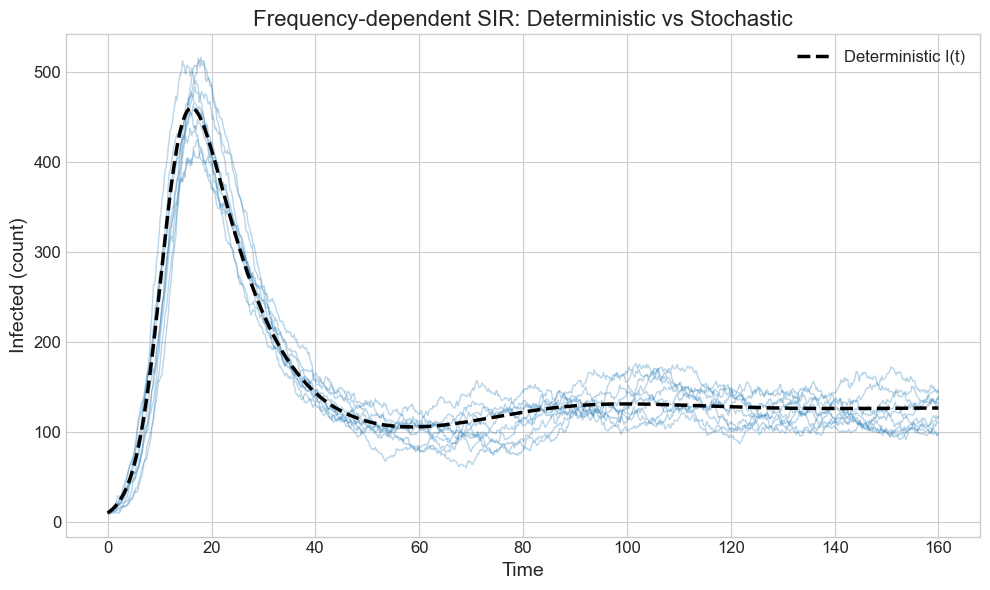

In [75]:
n_show = 10 # number of stochastic runs to show

fig, ax = plt.subplots()
for r in range(n_show):
    ax.plot(t_grid, I_paths[r, :], color="tab:blue", alpha=0.3, lw=1)

# Deterministic
ax.plot(det["t"], det["Y"], "k--", lw=2.5, label="Deterministic I(t)")

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("Infected (count)")
ax.set_title("Frequency-dependent SIR: Deterministic vs Stochastic")
ax.legend()

plt.tight_layout()
plt.show()

### Simulation Variability and Negative Co-variance

In [66]:
def run_ensemble(beta, gamma, mu, N, X0, Y0, Z0,
                 t_span=(0.0, 160.0), num_points=1000,
                 n_runs=200, seed0=12345):
    """
    Runs many Gillespie simulations and the deterministic ODE
    using counts (X,Y,Z). Returns t grid, deterministic curves,
    and stacked X/Y/Z paths.
    """
    # Use the counts-based integrator so keys are X,Y,Z
    det = integrate_sir(beta, gamma, mu, N, X0, Y0, Z0,
                               t_span=t_span, num_points=num_points)
    t_grid = det["t"]

    X_paths = np.zeros((n_runs, num_points))
    Y_paths = np.zeros((n_runs, num_points))
    Z_paths = np.zeros((n_runs, num_points))

    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax=t_span[1], rng=rng
        )
        X_paths[r, :] = resample_step(times, X_hist, t_grid)
        Y_paths[r, :] = resample_step(times, Y_hist, t_grid)
        Z_paths[r, :] = resample_step(times, Z_hist, t_grid)

    return t_grid, det, X_paths, Y_paths, Z_paths


In [67]:
def ensemble_stats(X_paths, Y_paths, Z_paths):
    """Compute time-wise mean/variance for X, Y, Z, and Cov[X,Y] (counts)."""
    X_mean = X_paths.mean(axis=0)
    Y_mean = Y_paths.mean(axis=0)
    Z_mean = Z_paths.mean(axis=0)

    X_var  = X_paths.var(axis=0, ddof=1)
    Y_var  = Y_paths.var(axis=0, ddof=1)
    Z_var  = Z_paths.var(axis=0, ddof=1)

    XY_mean = (X_paths * Y_paths).mean(axis=0)
    XY_cov  = XY_mean - X_mean * Y_mean

    return {
        "X_mean": X_mean, "Y_mean": Y_mean, "Z_mean": Z_mean,
        "X_var": X_var,   "Y_var": Y_var,   "Z_var": Z_var,
        "XY_cov": XY_cov
    }

In [68]:
from math import ceil

beta = 0.5
gamma = 0.1
mu = 1/50
t_span = (0, 160)
num_points = 1000
n_runs = 200

N_list = [500, 1000, 2000, 5000, 10000]
I0_fixed = 5
i0_frac = I0_fixed / 5000

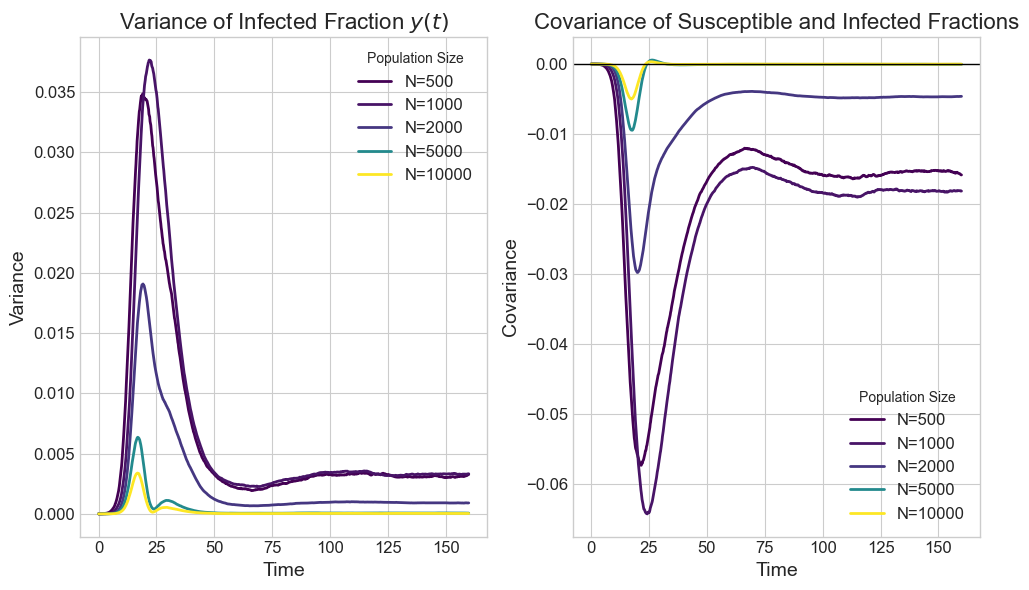

In [70]:
fig, (ax_var, ax_cov) = plt.subplots(1, 2)

Nmin, Nmax = min(N_list), max(N_list)

for N in N_list:
    # fixed initial fraction
    Y0 = max(1, int(ceil(i0_frac * N)))
    X0, Z0 = N - Y0, 0

    t, det, X_paths, Y_paths, Z_paths = run_ensemble(
        beta, gamma, mu, N, X0, Y0, Z0,
        t_span=t_span, num_points=num_points, n_runs=n_runs, seed0=6000
    )

    # convert to fractions
    y_paths = Y_paths / N
    x_paths = X_paths / N

    # normalized stats
    y_var = y_paths.var(axis=0, ddof=1)
    xy_mean = (x_paths * y_paths).mean(axis=0)
    xy_cov = xy_mean - x_paths.mean(axis=0) * y_paths.mean(axis=0)

    color = plt.cm.viridis((N - Nmin) / (Nmax - Nmin))

    # Variance of infected fraction
    ax_var.plot(t, y_var, color=color, label=f"N={N}")
    
    # Covariance of susceptible vs infected fractions
    ax_cov.plot(t, xy_cov, color=color, label=f"N={N}")

ax_cov.axhline(0, color="k", lw=1)

ax_var.set_title("Variance of Infected Fraction $y(t)$")
ax_var.set_xlabel("Time"); ax_var.set_ylabel("Variance")

ax_cov.set_title("Covariance of Susceptible and Infected Fractions")
ax_cov.set_xlabel("Time"); ax_cov.set_ylabel("Covariance")

ax_var.legend(title="Population Size")
ax_cov.legend(title="Population Size")

plt.tight_layout()
plt.show()

In [158]:
from scipy.signal import  find_peaks

def find_sir_equilibrium(beta, gamma, mu, N):
    """Find the endemic equilibrium for SIR with demography."""
    R0 = beta / (gamma + mu)
    if R0 <= 1.0:
        return (N, 0, 0) 
    else:
        X_eq = N / R0
        Y_eq = mu * N * (R0 - 1) / beta
        Z_eq = N - X_eq - Y_eq
        return (X_eq, Y_eq, Z_eq)

In [159]:
def compute_psd(y_signal, dt):
    """
    FFT-based PSD with correct one-sided normalization.
    Uses second half (steady-state), mean removal, Hann window.
    Returns freqs (1/time) and PSD with units 'power per (1/time)'.
    """
    # Steady-state half
    mid = len(y_signal) // 2
    y_steady = y_signal[mid:]

    # Detrend (mean) and window
    y_centered = y_steady - np.mean(y_steady)
    window = np.hanning(len(y_centered))
    y_windowed = y_centered * window

    # FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(len(y_windowed), d=dt)

    Fs = 1.0 / dt
    psd = (np.abs(fft_vals) ** 2) / (Fs * np.sum(window ** 2))

    if len(psd) > 2:
        psd[1:-1] *= 2

    return freqs, psd

In [160]:
def analyze_resonance(beta, gamma, mu, N, n_runs=30, tmax=400):
    """
    Analyze stochastic resonance: run simulations and compute averaged PSD.
    """
    # Setup
    t_grid = np.linspace(0, tmax, 4000)
    dt = t_grid[1] - t_grid[0]
    X_eq, Y_eq, Z_eq = find_sir_equilibrium(beta, gamma, mu, N)

    X0, Y0, Z0 = int(X_eq), max(1, int(Y_eq)), int(Z_eq)

    all_psds = []
    all_trajectories = []

    for run in range(n_runs):
        rng = np.random.default_rng(1000 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=rng
        )
        Y_uniform = resample_step(times, Y_hist, t_grid)
        all_trajectories.append(Y_uniform)

        freqs, psd = compute_psd(Y_uniform / N, dt)
        all_psds.append(psd)

    avg_psd = np.mean(all_psds, axis=0)

    f_nyq = 0.5 / dt
    f_low = 1.0 / tmax             
    f_high = min(0.1, 0.9 * f_nyq)
    mask = (freqs >= f_low) & (freqs <= f_high)
    
    peak_freq = None
    peak_power = None
    if np.any(mask):
        prom = np.percentile(avg_psd[mask], 85)
        peaks, properties = find_peaks(
            avg_psd[mask],
            prominence=max(1e-12, prom),
            width=1 
        )
        if len(peaks) > 0:
            masked_psd = avg_psd[mask]
            best = peaks[np.argmax(masked_psd[peaks])]
            peak_freq = freqs[mask][best]
            peak_power = masked_psd[best]

    return {
        'freqs': freqs,
        'avg_psd': avg_psd,
        'peak_freq': peak_freq,
        'peak_power': peak_power,
        'trajectories': all_trajectories,
        't_grid': t_grid,
        'Y_eq': Y_eq
    }

In [170]:
def analyze_transients(beta, gamma, mu, N, n_runs=30, tmax=300, i0_frac=0.01,
                       extinct_thresh_frac=1e-4):
    """
    Start at Y0 = i0_frac*N (>=1). Measure overshoot & time-to-peak using FRACTIONS.
    Also returns the fraction of runs that went effectively extinct.
    """
    X_eq, Y_eq, Z_eq = find_sir_equilibrium(beta, gamma, mu, N)
    y_star = Y_eq / N

    Y0 = max(1, int(round(i0_frac * N)))
    X0, Z0 = N - Y0, 0

    t_grid = np.linspace(0, tmax, 4000)
    peaks, tpeaks, alive = [], [], 0

    for run in range(n_runs):
        rng = np.random.default_rng(2000 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=rng
        )
        Y_uni = resample_step(times, Y_hist, t_grid) / N
        pk_idx = int(np.argmax(Y_uni))
        pk_val = float(Y_uni[pk_idx])

        peaks.append(pk_val)
        tpeaks.append(t_grid[pk_idx])
        # count as "alive" if it ever rose above a tiny fraction
        if np.max(Y_uni) > extinct_thresh_frac:
            alive += 1

    peaks = np.array(peaks); tpeaks = np.array(tpeaks)
    mean_peak = float(np.mean(peaks)) if len(peaks) else 0.0
    overshoot = (mean_peak - y_star) / y_star if (y_star > 0 and len(peaks)) else 0.0
    extinct_rate = 1.0 - (alive / n_runs)

    return {
        'y_star': y_star,
        'mean_peak_frac': mean_peak,
        'mean_peak_time': float(np.mean(tpeaks)) if len(tpeaks) else 0.0,
        'overshoot': overshoot,            # dimensionless, fraction-based
        'extinct_rate': extinct_rate       # fraction of runs that faded out
    }


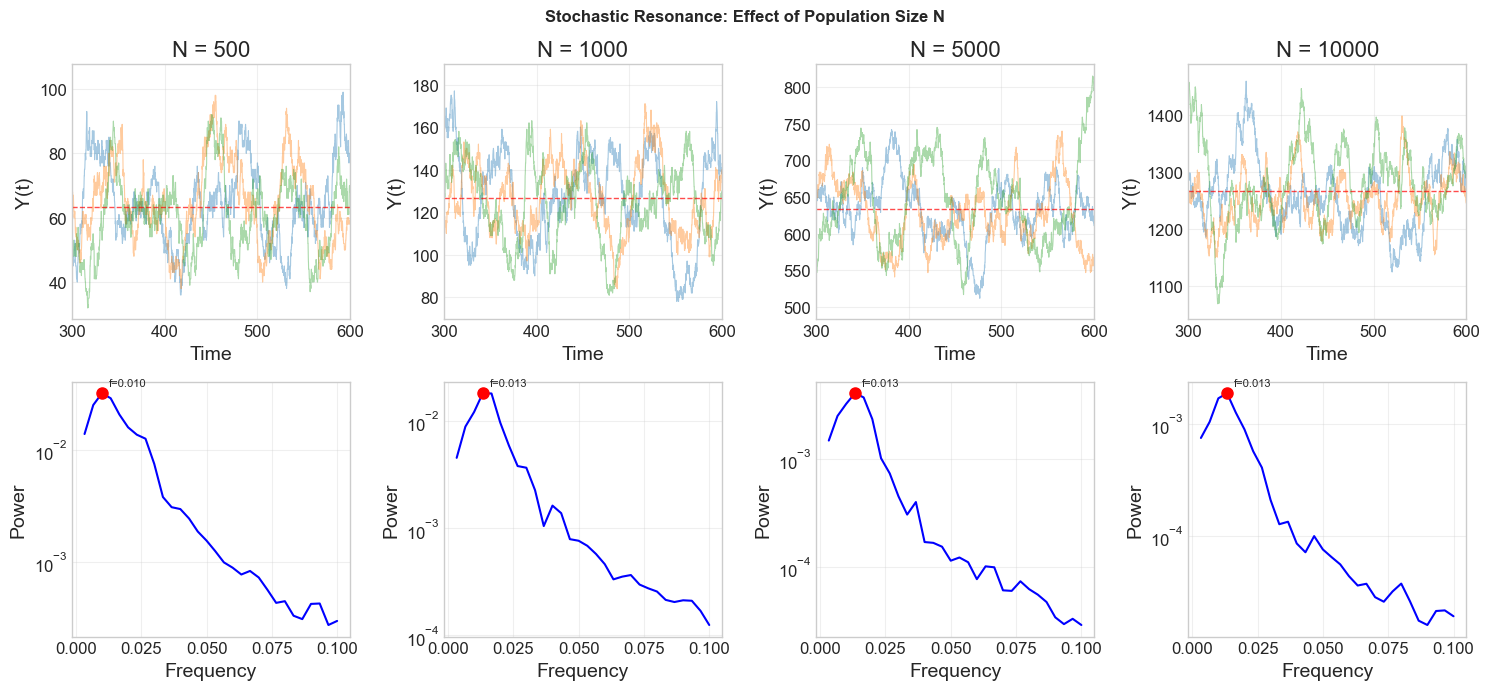

In [171]:
gamma = 0.1
mu = 1/50
N_values = [500, 1000, 5000, 10000]
beta = 0.5

fig, axes = plt.subplots(2, len(N_values), figsize=(15, 7))

resonance_results = []
for idx, N in enumerate(N_values):
    res = analyze_resonance(beta, gamma, mu, N, n_runs=20, tmax=600)
    resonance_results.append(res)
    
    # Top: Sample trajectories
    ax = axes[0, idx]
    for i in range(min(3, len(res['trajectories']))):
        ax.plot(res['t_grid'], res['trajectories'][i], alpha=0.4, lw=0.8)
    ax.axhline(res['Y_eq'], ls='--', lw=1.0, alpha=0.7, color='red', label='Y*')
    ax.set_title(f'N = {N}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Y(t)')
    ax.set_xlim([300, 600])
    ax.grid(True, alpha=0.3)
    
    # Bottom: Power spectrum
    ax = axes[1, idx]
    mask = (res['freqs'] > 0) & (res['freqs'] < 0.1)
    ax.semilogy(res['freqs'][mask], res['avg_psd'][mask], 'b-', lw=1.5)
    
    if res['peak_freq'] is not None:
        ax.plot(res['peak_freq'], res['peak_power'], 'ro', markersize=8)
        ax.annotate(f"f={res['peak_freq']:.3f}", 
                   xy=(res['peak_freq'], res['peak_power']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.grid(True, alpha=0.3)

plt.suptitle('Stochastic Resonance: Effect of Population Size N', fontweight='bold')
plt.tight_layout()
plt.show()

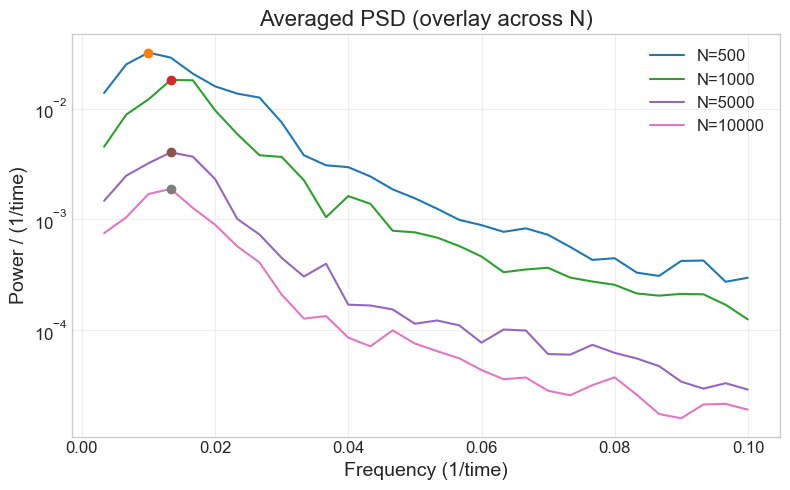

In [172]:
fig, ax = plt.subplots(figsize=(8,5))
for N, res in zip(N_values, resonance_results):
    f_low, f_high = 1/res['t_grid'][-1], 0.1
    mask = (res['freqs'] >= f_low) & (res['freqs'] <= f_high)
    ax.semilogy(res['freqs'][mask], res['avg_psd'][mask], lw=1.5, label=f'N={N}')
    if res['peak_freq'] is not None:
        ax.plot(res['peak_freq'], res['peak_power'], 'o')

ax.set_xlabel('Frequency (1/time)')
ax.set_ylabel('Power / (1/time)')
ax.set_title('Averaged PSD (overlay across N)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout(); plt.show()

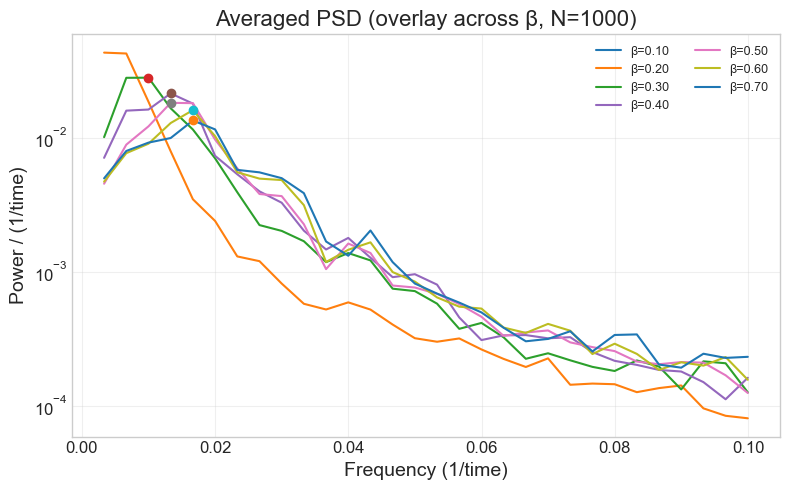

In [173]:
N_fixed = 1000
beta_grid = np.arange(0.1, 0.71, 0.1) 
psd_by_beta = []

for b in beta_grid:
    res = analyze_resonance(b, gamma, mu, N_fixed, n_runs=20, tmax=600)
    psd_by_beta.append(res)

fig, ax = plt.subplots(figsize=(8,5))
for b, res in zip(beta_grid, psd_by_beta):
  
    f_low, f_high = 1/res['t_grid'][-1], 0.1
    mask = (res['freqs'] >= f_low) & (res['freqs'] <= f_high)
    ax.semilogy(res['freqs'][mask], res['avg_psd'][mask], lw=1.5, label=f'β={b:.2f}')
    if res['peak_freq'] is not None:
        ax.plot(res['peak_freq'], res['peak_power'], 'o')

ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_title(f'Averaged PSD (overlay across β, N={N_fixed})')
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.show()